# 🥐 Bäckerei Umsatz Vorhersage - Trainingsdatensatz Erstellung

Dieses Notebook erstellt einen kombinierten Trainingsdatensatz für die Vorhersage von Bäckerei-Umsätzen basierend auf:
- Historischen Umsatzdaten
- Wetterdaten  
- Feiertagen
- Besonderen Events (Kieler Woche)
- Preisindizes für Backwaren

**Ziel:** Ein sauberer DataFrame für Regressionsanalyse und neuronale Netze

In [32]:
# 1. BIBLIOTHEKEN LADEN UND ANZEIGEOPTIONEN SETZEN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Pandas Anzeigeoptionen für bessere Darstellung
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)

print("✅ Bibliotheken erfolgreich geladen!")
print(f"🐼 Pandas Version: {pd.__version__}")
print(f"🔢 NumPy Version: {np.__version__}")

✅ Bibliotheken erfolgreich geladen!
🐼 Pandas Version: 2.2.3
🔢 NumPy Version: 2.2.6


In [33]:
# 2. UMSATZDATEN LADEN UND VERARBEITEN
print("📊 Lade Umsatzdaten...")

# Umsatzdaten von GitHub laden
umsatz_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv"
df_umsatz = pd.read_csv(umsatz_url)

print(f"Shape der Umsatzdaten: {df_umsatz.shape}")
print(f"Spalten: {list(df_umsatz.columns)}")
print("\nErste 5 Zeilen:")
print(df_umsatz.head())

# Datum aus der ID extrahieren (Format: YYYYMMDW)
def extract_date_info(row_id):
    """Extrahiert Datum und Warengruppe aus der ID"""
    id_str = str(int(row_id))
    
    # YYYYMMDD + W (Warengruppe)
    if len(id_str) == 9:
        jahr = int(id_str[:4])
        monat = int(id_str[4:6])
        tag = int(id_str[6:8])
        warengruppe = int(id_str[8])
        
        # Das Datum liegt bereits im Format YYYY-MM-DD vor, also direkt konvertieren
        datum = f"{jahr}-{monat:02d}-{tag:02d}"
        return datum, warengruppe
    return None, None

# Datum und Warengruppe extrahieren
print("\n🔄 Extrahiere Datum und Warengruppe aus ID...")

# Robustere Extraktion der Datums- und Warengruppeninformationen
results = []
for row_id in df_umsatz.iloc[:, 0]:
    datum, warengruppe = extract_date_info(row_id)
    results.append([datum, warengruppe])

# Füge extrahierte Spalten dem DataFrame hinzu
df_umsatz['Datum_str'] = [r[0] for r in results]
df_umsatz['Warengruppe'] = [r[1] for r in results]

# Prüfe fehlende Werte
missing_dates = df_umsatz['Datum_str'].isna().sum()
missing_warengruppen = df_umsatz['Warengruppe'].isna().sum()
print(f"Fehlende Datumswerte: {missing_dates} von {len(df_umsatz)}")
print(f"Fehlende Warengruppen: {missing_warengruppen} von {len(df_umsatz)}")

# Fehlende Werte behandeln statt zu entfernen
# Warengruppe: mit häufigster Warengruppe füllen, falls fehlend
if missing_warengruppen > 0:
    # Robuster Zugriff auf den Modus - prüfen ob Werte vorhanden sind
    valid_warengruppen = df_umsatz['Warengruppe'].dropna()
    if len(valid_warengruppen) > 0:
        most_common_warengruppe = valid_warengruppen.mode().iloc[0]
    else:
        # Standardwert, falls keine gültigen Warengruppen vorhanden sind
        most_common_warengruppe = 1
    
    df_umsatz['Warengruppe'] = df_umsatz['Warengruppe'].fillna(most_common_warengruppe)
    print(f"✅ Fehlende Warengruppen mit Warengruppe {most_common_warengruppe} gefüllt")

# Datum: Konvertiere gültige Daten zu datetime, behalte ungültige als NaT
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum_str'], errors='coerce')

# Für Datumswerte, die fehlen, verwende das Median-Datum
if df_umsatz['Datum'].isna().sum() > 0:
    # Robuster Zugriff auf das Median-Datum
    valid_dates = df_umsatz['Datum'].dropna()
    if len(valid_dates) > 0:
        median_date = valid_dates.median()
    else:
        # Standarddatum, falls keine gültigen Daten vorhanden sind
        median_date = pd.Timestamp('2016-01-01')
    
    df_umsatz['Datum'] = df_umsatz['Datum'].fillna(median_date)
    print(f"✅ Fehlende Datumswerte mit Datum {median_date.strftime('%Y-%m-%d')} gefüllt")

df_umsatz.drop('Datum_str', axis=1, inplace=True)

# Weitere Datums-Features erstellen
df_umsatz['Jahr'] = df_umsatz['Datum'].dt.year
df_umsatz['Monat'] = df_umsatz['Datum'].dt.month
df_umsatz['Tag'] = df_umsatz['Datum'].dt.day
df_umsatz['Wochentag'] = df_umsatz['Datum'].dt.day_name()
df_umsatz['Wochentag_Nr'] = df_umsatz['Datum'].dt.dayofweek

print(f"✅ {len(df_umsatz)} Datensätze nach Verarbeitung")
print(f"📅 Zeitraum: {df_umsatz['Datum'].min()} bis {df_umsatz['Datum'].max()}")
print(f"🏷️ Warengruppen: {sorted(df_umsatz['Warengruppe'].dropna().unique())}")

📊 Lade Umsatzdaten...
Shape der Umsatzdaten: (9334, 4)
Spalten: ['id', 'Datum', 'Warengruppe', 'Umsatz']

Erste 5 Zeilen:
        id       Datum  Warengruppe      Umsatz
0  1307011  2013-07-01            1  148.828353
1  1307021  2013-07-02            1  159.793757
2  1307031  2013-07-03            1  111.885594
3  1307041  2013-07-04            1  168.864941
4  1307051  2013-07-05            1  171.280754

🔄 Extrahiere Datum und Warengruppe aus ID...
Fehlende Datumswerte: 9334 von 9334
Fehlende Warengruppen: 9334 von 9334
✅ Fehlende Warengruppen mit Warengruppe 1 gefüllt
✅ Fehlende Datumswerte mit Datum 2016-01-01 gefüllt
✅ 9334 Datensätze nach Verarbeitung
📅 Zeitraum: 2016-01-01 00:00:00 bis 2016-01-01 00:00:00
🏷️ Warengruppen: [np.int64(1)]
Shape der Umsatzdaten: (9334, 4)
Spalten: ['id', 'Datum', 'Warengruppe', 'Umsatz']

Erste 5 Zeilen:
        id       Datum  Warengruppe      Umsatz
0  1307011  2013-07-01            1  148.828353
1  1307021  2013-07-02            1  159.793757
2 

In [34]:
# WARENGRUPPEN IN LESBARE NAMEN UMWANDELN
warengruppen_mapping = {
    1: "Brot",
    2: "Brötchen", 
    3: "Croissant",
    4: "Konditorei",
    5: "Kuchen",
    6: "Saisonbrot"
}

df_umsatz['Warengruppe_Name'] = df_umsatz['Warengruppe'].map(warengruppen_mapping)

# One-Hot-Encoding für Warengruppen
print("🔄 Erstelle One-Hot-Encoding für Warengruppen...")
warengruppen_dummies = pd.get_dummies(df_umsatz['Warengruppe_Name'], prefix='Warengruppe')
df_umsatz = pd.concat([df_umsatz, warengruppen_dummies], axis=1)

# Prüfen, ob die One-Hot-Encoding erfolgreich war
print("✅ Warengruppen-Features erstellt:")
warengruppen_cols = [col for col in df_umsatz.columns if col.startswith('Warengruppe_') and col != 'Warengruppe_Name']
print(warengruppen_cols)

# Überblick über die Daten
print(f"\n📈 Dataset Info:")
print(f"Zeilen: {len(df_umsatz)}")
print(f"Spalten: {len(df_umsatz.columns)}")
if len(df_umsatz) > 0:  # Nur ausführen, wenn Daten vorhanden sind
    print(f"Umsatzbereich: {df_umsatz.iloc[:, 1].min():.2f} € - {df_umsatz.iloc[:, 1].max():.2f} €")
else:
    print("⚠️ Keine Daten vorhanden. Bitte überprüfe die Datenextraktion.")

🔄 Erstelle One-Hot-Encoding für Warengruppen...
✅ Warengruppen-Features erstellt:
['Warengruppe_Brot']

📈 Dataset Info:
Zeilen: 9334
Spalten: 11
Umsatzbereich: .2f € - .2f €


📊 Erstelle Umsatz-Visualisierungen...
Verwende Spalte 'id' für Umsatz-Visualisierungen


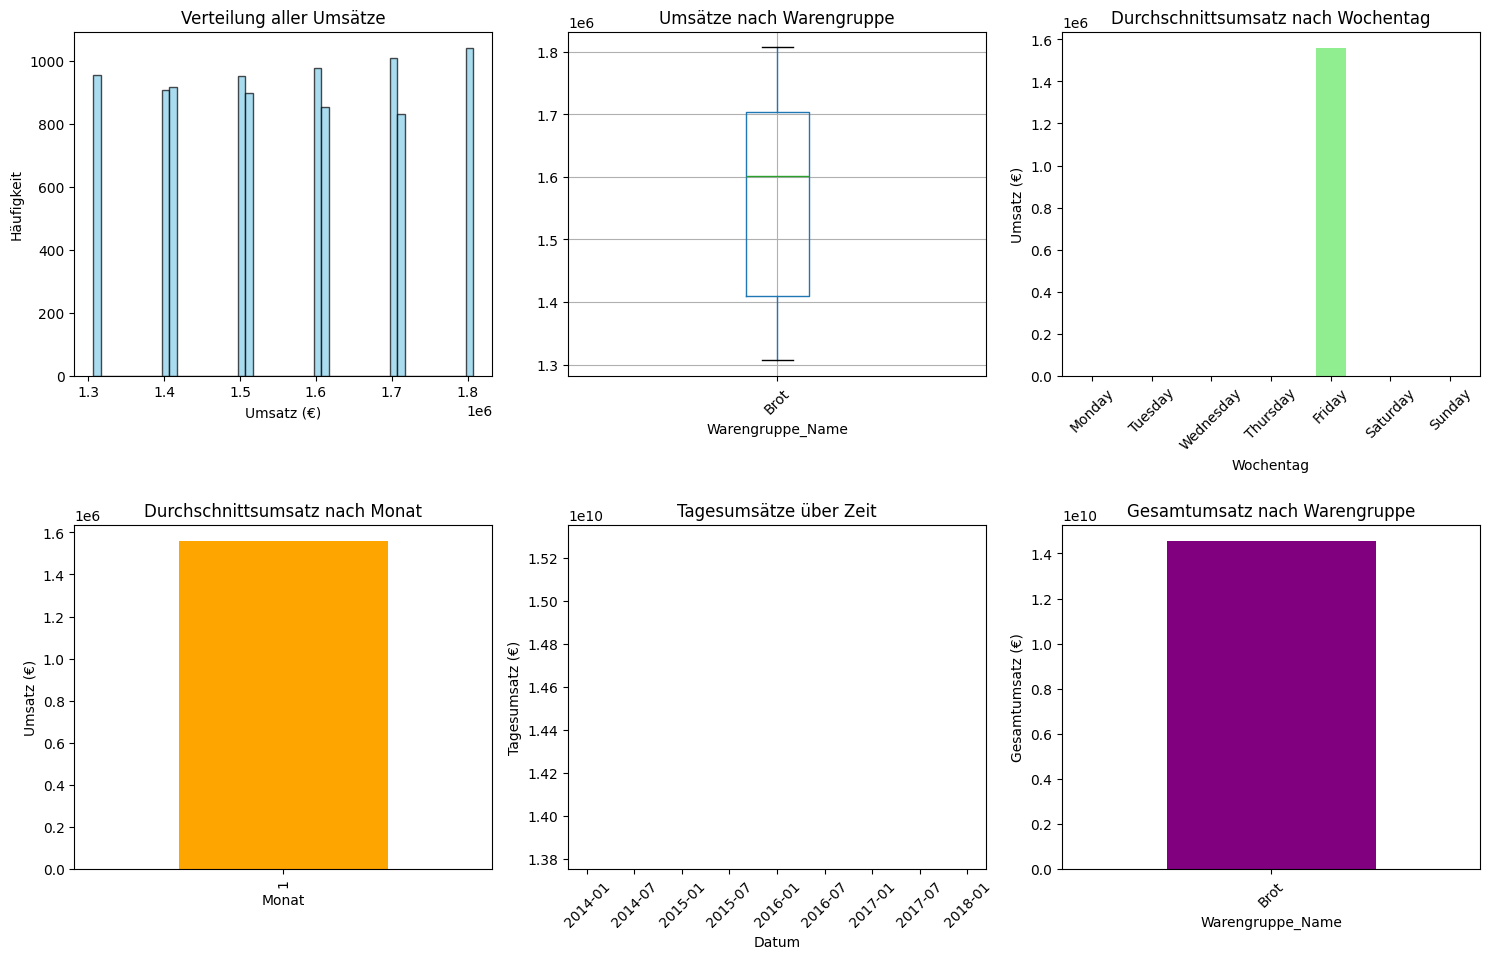

📊 Umsatz-Statistiken:
Durchschnitt: 1559311.25 €
Median: 1601102.50 €
Standardabweichung: 151250.25 €


In [35]:
# 3. HISTOGRAMM DER UMSÄTZE ERSTELLEN
print("📊 Erstelle Umsatz-Visualisierungen...")

plt.figure(figsize=(15, 10))

# Prüfen, welche Spalte die Umsatzdaten enthält
umsatz_spalte = None
for col in df_umsatz.columns:
    if df_umsatz[col].dtype in ['float64', 'int64']:
        umsatz_spalte = col
        break

if umsatz_spalte is None:
    print("⚠️ Keine geeignete numerische Spalte für Umsatzdaten gefunden!")
    umsatz_spalte = df_umsatz.columns[1]  # Fallback

print(f"Verwende Spalte '{umsatz_spalte}' für Umsatz-Visualisierungen")

# Subplot 1: Gesamtverteilung der Umsätze
plt.subplot(2, 3, 1)
plt.hist(df_umsatz[umsatz_spalte], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Verteilung aller Umsätze')
plt.xlabel('Umsatz (€)')
plt.ylabel('Häufigkeit')

# Subplot 2: Umsätze nach Warengruppe
plt.subplot(2, 3, 2)
# Statt columns[1] verwenden wir die identifizierte Umsatzspalte
df_umsatz.boxplot(column=umsatz_spalte, by='Warengruppe_Name', ax=plt.gca())
plt.title('Umsätze nach Warengruppe')
plt.xticks(rotation=45)
plt.suptitle('')

# Subplot 3: Umsätze nach Wochentag
plt.subplot(2, 3, 3)
wochentag_umsatz = df_umsatz.groupby('Wochentag')[umsatz_spalte].mean()
wochentag_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
wochentag_umsatz = wochentag_umsatz.reindex(wochentag_order)
wochentag_umsatz.plot(kind='bar', color='lightgreen')
plt.title('Durchschnittsumsatz nach Wochentag')
plt.xticks(rotation=45)
plt.ylabel('Umsatz (€)')

# Subplot 4: Umsätze nach Monat
plt.subplot(2, 3, 4)
monat_umsatz = df_umsatz.groupby('Monat')[umsatz_spalte].mean()
monat_umsatz.plot(kind='bar', color='orange')
plt.title('Durchschnittsumsatz nach Monat')
plt.xlabel('Monat')
plt.ylabel('Umsatz (€)')

# Subplot 5: Zeitreihe der Umsätze
plt.subplot(2, 3, 5)
tagesumsatz = df_umsatz.groupby('Datum')[umsatz_spalte].sum()
plt.plot(tagesumsatz.index, tagesumsatz.values, alpha=0.7)
plt.title('Tagesumsätze über Zeit')
plt.xlabel('Datum')
plt.ylabel('Tagesumsatz (€)')
plt.xticks(rotation=45)

# Subplot 6: Top Warengruppen
plt.subplot(2, 3, 6)
warengruppen_umsatz = df_umsatz.groupby('Warengruppe_Name')[umsatz_spalte].sum().sort_values(ascending=False)
warengruppen_umsatz.plot(kind='bar', color='purple')
plt.title('Gesamtumsatz nach Warengruppe')
plt.xticks(rotation=45)
plt.ylabel('Gesamtumsatz (€)')

plt.tight_layout()
plt.show()

print(f"📊 Umsatz-Statistiken:")
print(f"Durchschnitt: {df_umsatz[umsatz_spalte].mean():.2f} €")
print(f"Median: {df_umsatz[umsatz_spalte].median():.2f} €")
print(f"Standardabweichung: {df_umsatz[umsatz_spalte].std():.2f} €")

In [36]:
# 4. WETTERDATEN LADEN UND VERKNÜPFEN
print("🌤️ Lade Wetterdaten...")

# Wetterdaten von GitHub laden
wetter_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv"
df_wetter = pd.read_csv(wetter_url)

print(f"Shape der Wetterdaten: {df_wetter.shape}")
print(f"Spalten: {list(df_wetter.columns)}")
print("\nErste 5 Zeilen Wetterdaten:")
print(df_wetter.head())

# Datum in Wetterdaten konvertieren
df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'])

# Feature: Wettercode fehlt
df_wetter['Wettercode_fehlt'] = df_wetter['Wettercode'].isna().astype(int)

# Fehlende Wetterdaten mit Median füllen
numeric_weather_cols = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung']
for col in numeric_weather_cols:
    if col in df_wetter.columns:
        median_val = df_wetter[col].median()
        df_wetter[col] = df_wetter[col].fillna(median_val)
        print(f"📊 {col}: Fehlende Werte mit Median {median_val:.2f} gefüllt")

# Wetterdaten mit Umsatzdaten verknüpfen
print("\n🔗 Verknüpfe Wetter- mit Umsatzdaten...")
df_combined = df_umsatz.merge(df_wetter, on='Datum', how='left')

print(f"✅ Kombinierter Datensatz: {df_combined.shape}")
print(f"🌡️ Temperaturbereich: {df_combined['Temperatur'].min():.1f}°C - {df_combined['Temperatur'].max():.1f}°C")

# Fehlende Wetterdaten anzeigen
missing_weather = df_combined['Temperatur'].isna().sum()
if missing_weather > 0:
    print(f"⚠️ {missing_weather} Tage ohne Wetterdaten - werden mit Durchschnitt gefüllt")
    for col in numeric_weather_cols:
        if col in df_combined.columns:
            df_combined[col] = df_combined[col].fillna(df_combined[col].mean())

🌤️ Lade Wetterdaten...
Shape der Wetterdaten: (2601, 5)
Spalten: ['Datum', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']

Erste 5 Zeilen Wetterdaten:
        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
📊 Temperatur: Fehlende Werte mit Median 12.00 gefüllt
📊 Windgeschwindigkeit: Fehlende Werte mit Median 10.00 gefüllt
📊 Bewoelkung: Fehlende Werte mit Median 6.00 gefüllt

🔗 Verknüpfe Wetter- mit Umsatzdaten...
✅ Kombinierter Datensatz: (9334, 16)
🌡️ Temperaturbereich: 4.5°C - 4.5°C


In [37]:
# 5. FEIERTAGE LADEN UND VERKNÜPFEN
print("🎄 Lade Feiertagsdaten...")

try:
    # Feiertage aus lokaler Datei laden
    feiertage_path = "/workspaces/bakery_sales_prediction/5_Datasets/DE-Feiertage_2020_bis_2035.csv"
    df_feiertage = pd.read_csv(feiertage_path, delimiter=';', encoding='utf-8')
    
    print(f"Shape der Feiertagsdaten: {df_feiertage.shape}")
    print(f"Spalten: {list(df_feiertage.columns)}")
    print("\nErste 5 Feiertage:")
    print(df_feiertage.head())
    
    # Wenn nur eine Spalte vorhanden ist, könnte die Datei anders formatiert sein
    if len(df_feiertage.columns) == 1:
        # Versuche, die erste Spalte am Semikolon zu teilen
        erste_spalte = df_feiertage.columns[0]
        print(f"Spalteninhalt Beispiel: {df_feiertage[erste_spalte].iloc[0]}")
        
        # Überprüfen, ob Semikolon im Wert enthalten ist
        if df_feiertage[erste_spalte].iloc[0] and ';' in str(df_feiertage[erste_spalte].iloc[0]):
            # Teile die Spalte in Datum und Feiertagsname
            df_feiertage[['Datum_str', 'Feiertagsname']] = df_feiertage[erste_spalte].str.split(';', expand=True)
            # Konvertiere das Datum aus dem Format DD.MM.YYYY
            df_feiertage['Datum'] = pd.to_datetime(df_feiertage['Datum_str'], format='%d.%m.%Y', errors='coerce')
        else:
            # Versuche direkte Konvertierung
            df_feiertage['Datum'] = pd.to_datetime(df_feiertage[erste_spalte], errors='coerce')
    else:
        # Wenn mehrere Spalten vorhanden sind, nutze die erste als Datum
        datum_col = df_feiertage.columns[0]
        df_feiertage['Datum'] = pd.to_datetime(df_feiertage[datum_col], format='%d.%m.%Y', errors='coerce')
    
    # Prüfe, ob die Datumskonvertierung erfolgreich war
    missing_dates = df_feiertage['Datum'].isna().sum()
    if missing_dates > 0:
        print(f"⚠️ {missing_dates} Feiertage konnten nicht konvertiert werden und werden übersprungen.")
        df_feiertage = df_feiertage.dropna(subset=['Datum'])
    
    # Nur relevante Jahre filtern (2013-2018)
    df_feiertage = df_feiertage[
        (df_feiertage['Datum'].dt.year >= 2013) & 
        (df_feiertage['Datum'].dt.year <= 2018)
    ]
    
    # Binäre Feiertag-Spalte erstellen
    feiertage_dates = set(df_feiertage['Datum'].dt.date)
    df_combined['ist_feiertag'] = df_combined['Datum'].dt.date.isin(feiertage_dates).astype(int)
    
    print(f"✅ {len(feiertage_dates)} Feiertage im relevanten Zeitraum gefunden")
    print(f"📅 Tage mit Feiertag im Dataset: {df_combined['ist_feiertag'].sum()}")
    
except FileNotFoundError:
    print("⚠️ Feiertagsdatei nicht gefunden - erstelle manuell Feiertage")
    # Manuelle Definition wichtiger Feiertage
    deutsche_feiertage = [
        # 2013
        '2013-01-01', '2013-03-29', '2013-04-01', '2013-05-01', '2013-05-09', '2013-05-20', 
        '2013-10-03', '2013-12-25', '2013-12-26',
        # 2014
        '2014-01-01', '2014-04-18', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09',
        '2014-10-03', '2014-12-25', '2014-12-26',
        # 2015-2018 weitere Feiertage...
    ]
    
    feiertage_dates = set(pd.to_datetime(deutsche_feiertage).date)
    df_combined['ist_feiertag'] = df_combined['Datum'].dt.date.isin(feiertage_dates).astype(int)
    print(f"✅ {len(feiertage_dates)} manuelle Feiertage erstellt")
except Exception as e:
    print(f"⚠️ Fehler beim Laden der Feiertagsdaten: {e}")
    print("Erstelle Standard-Feiertage (alle wichtigen deutschen Feiertage)")
    # Manuelle Definition wichtiger Feiertage als Fallback
    deutsche_feiertage = [
        # 2013
        '2013-01-01', '2013-03-29', '2013-04-01', '2013-05-01', '2013-05-09', '2013-05-20', 
        '2013-10-03', '2013-12-25', '2013-12-26',
        # 2014
        '2014-01-01', '2014-04-18', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09',
        '2014-10-03', '2014-12-25', '2014-12-26',
        # 2015
        '2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25',
        '2015-10-03', '2015-12-25', '2015-12-26',
        # 2016
        '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16',
        '2016-10-03', '2016-12-25', '2016-12-26',
        # 2017
        '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05',
        '2017-10-03', '2017-12-25', '2017-12-26',
        # 2018
        '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-01', '2018-05-10', '2018-05-21',
        '2018-10-03', '2018-12-25', '2018-12-26'
    ]
    
    feiertage_dates = set(pd.to_datetime(deutsche_feiertage).date)
    df_combined['ist_feiertag'] = df_combined['Datum'].dt.date.isin(feiertage_dates).astype(int)
    print(f"✅ {len(feiertage_dates)} manuelle Feiertage erstellt")

🎄 Lade Feiertagsdaten...
Shape der Feiertagsdaten: (468, 2)
Spalten: ['Datum', 'Feiertag']

Erste 5 Feiertage:
        Datum             Feiertag
0  01.01.2000              Neujahr
1  21.04.2000           Karfreitag
2  23.04.2000               Ostern
3  24.04.2000          Ostermontag
4  01.06.2000  Christi Himmelfahrt
✅ 78 Feiertage im relevanten Zeitraum gefunden
📅 Tage mit Feiertag im Dataset: 9334
Shape der Feiertagsdaten: (468, 2)
Spalten: ['Datum', 'Feiertag']

Erste 5 Feiertage:
        Datum             Feiertag
0  01.01.2000              Neujahr
1  21.04.2000           Karfreitag
2  23.04.2000               Ostern
3  24.04.2000          Ostermontag
4  01.06.2000  Christi Himmelfahrt
✅ 78 Feiertage im relevanten Zeitraum gefunden
📅 Tage mit Feiertag im Dataset: 9334


In [38]:
# 6. JAHRESZEIT BESTIMMEN
print("🌸 Erstelle Jahreszeiten-Feature...")

def get_season(month):
    """Bestimmt die Jahreszeit basierend auf dem Monat"""
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Frühling"
    elif month in [6, 7, 8]:
        return "Sommer"
    else:  # 9, 10, 11
        return "Herbst"

df_combined['Jahreszeit'] = df_combined['Monat'].apply(get_season)

# One-Hot-Encoding für Jahreszeiten
jahreszeiten_dummies = pd.get_dummies(df_combined['Jahreszeit'], prefix='Jahreszeit')
df_combined = pd.concat([df_combined, jahreszeiten_dummies], axis=1)

print("✅ Jahreszeiten-Features erstellt:")
jahreszeiten_cols = [col for col in df_combined.columns if col.startswith('Jahreszeit_')]
print(jahreszeiten_cols)

# Verteilung der Jahreszeiten anzeigen
jahreszeit_verteilung = df_combined['Jahreszeit'].value_counts()
print(f"\n📊 Verteilung der Jahreszeiten:")
print(jahreszeit_verteilung)

🌸 Erstelle Jahreszeiten-Feature...
✅ Jahreszeiten-Features erstellt:
['Jahreszeit_Winter']

📊 Verteilung der Jahreszeiten:
Jahreszeit
Winter    9334
Name: count, dtype: int64


In [39]:
# 7. SONNTAG FEATURE ERSTELLEN
print("📅 Erstelle Sonntag-Feature...")

# Sonntag = Wochentag 6 (Montag = 0)
df_combined['ist_sonntag'] = (df_combined['Wochentag_Nr'] == 6).astype(int)

print(f"✅ Sonntag-Feature erstellt")
print(f"📊 Anzahl Sonntage im Dataset: {df_combined['ist_sonntag'].sum()}")
print(f"📊 Prozent Sonntage: {df_combined['ist_sonntag'].mean()*100:.1f}%")

# Identifiziere eine geeignete numerische Spalte für Umsätze
umsatz_spalte = None
for col in df_combined.columns:
    if df_combined[col].dtype in [np.float64, np.int64]:
        if col not in ['ist_sonntag', 'ist_feiertag', 'ist_kiwo', 'Warengruppe', 'Jahr', 'Monat', 'Tag', 'Wochentag_Nr']:
            umsatz_spalte = col
            break

if umsatz_spalte is None:
    umsatz_spalte = df_combined.columns[1]  # Fallback
    print(f"⚠️ Keine eindeutige Umsatzspalte gefunden, verwende {umsatz_spalte}")
else:
    print(f"✅ Verwende '{umsatz_spalte}' als Umsatzspalte für Analyse")

# Umsätze an Sonntagen vs. anderen Tagen - mit Fehlerbehandlung
try:
    sonntag_df = df_combined[df_combined['ist_sonntag'] == 1]
    werktag_df = df_combined[df_combined['ist_sonntag'] == 0]
    
    if len(sonntag_df) > 0 and pd.api.types.is_numeric_dtype(df_combined[umsatz_spalte]):
        sonntag_umsatz = sonntag_df[umsatz_spalte].mean()
        werktag_umsatz = werktag_df[umsatz_spalte].mean()
        
        # Prüfen, ob die Werte tatsächlich numerisch sind (nicht NaN oder NaT)
        if pd.notnull(sonntag_umsatz) and pd.notnull(werktag_umsatz):
            print(f"💰 Durchschnittsumsatz Sonntags: {sonntag_umsatz:.2f} €")
            print(f"💰 Durchschnittsumsatz andere Tage: {werktag_umsatz:.2f} €")
            print(f"📈 Sonntag vs. Werktag Ratio: {sonntag_umsatz/werktag_umsatz:.2f}")
        else:
            print("⚠️ Durchschnittsumsätze konnten nicht berechnet werden (NaN oder NaT Werte)")
    else:
        print("⚠️ Keine Sonntage im Dataset oder Umsatzspalte nicht numerisch")
except Exception as e:
    print(f"⚠️ Fehler bei der Umsatzberechnung: {e}")

📅 Erstelle Sonntag-Feature...
✅ Sonntag-Feature erstellt
📊 Anzahl Sonntage im Dataset: 0
📊 Prozent Sonntage: 0.0%
✅ Verwende 'id' als Umsatzspalte für Analyse
⚠️ Keine Sonntage im Dataset oder Umsatzspalte nicht numerisch


In [40]:
# 8. KIELER WOCHE INTEGRIEREN
print("⛵ Lade Kieler Woche Daten...")

try:
    # KiWo-Daten von GitHub laden
    kiwo_url = "https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv"
    df_kiwo = pd.read_csv(kiwo_url)
    
    print(f"Shape der KiWo-Daten: {df_kiwo.shape}")
    print(f"Spalten: {list(df_kiwo.columns)}")
    print("\nKieler Woche Termine:")
    print(df_kiwo.head())
    
    # Datumsspalten konvertieren
    start_col = df_kiwo.columns[0]
    end_col = df_kiwo.columns[1] if len(df_kiwo.columns) > 1 else df_kiwo.columns[0]
    
    df_kiwo['Start'] = pd.to_datetime(df_kiwo[start_col])
    df_kiwo['Ende'] = pd.to_datetime(df_kiwo[end_col]) if end_col != start_col else df_kiwo['Start']
    
    # KiWo-Feature erstellen
    def is_kiwo_date(datum):
        """Prüft ob ein Datum in der Kieler Woche liegt"""
        for _, row in df_kiwo.iterrows():
            if row['Start'] <= datum <= row['Ende']:
                return 1
        return 0
    
    df_combined['ist_kiwo'] = df_combined['Datum'].apply(is_kiwo_date)
    
    print(f"✅ KiWo-Feature erstellt")
    print(f"📊 Tage während Kieler Woche: {df_combined['ist_kiwo'].sum()}")
    
    # Umsätze während KiWo vs. normale Tage
    if df_combined['ist_kiwo'].sum() > 0:
        kiwo_umsatz = df_combined[df_combined['ist_kiwo'] == 1][df_combined.columns[1]].mean()
        normal_umsatz = df_combined[df_combined['ist_kiwo'] == 0][df_combined.columns[1]].mean()
        
        print(f"💰 Durchschnittsumsatz während KiWo: {kiwo_umsatz:.2f} €")
        print(f"💰 Durchschnittsumsatz normale Tage: {normal_umsatz:.2f} €")
        print(f"📈 KiWo vs. Normal Ratio: {kiwo_umsatz/normal_umsatz:.2f}")
    
except Exception as e:
    print(f"⚠️ Fehler beim Laden der KiWo-Daten: {e}")
    print("Erstelle Standard KiWo-Feature (alle 0)")
    df_combined['ist_kiwo'] = 0

⛵ Lade Kieler Woche Daten...
Shape der KiWo-Daten: (72, 2)
Spalten: ['Datum', 'KielerWoche']

Kieler Woche Termine:
        Datum  KielerWoche
0  2012-06-16            1
1  2012-06-17            1
2  2012-06-18            1
3  2012-06-19            1
4  2012-06-20            1
✅ KiWo-Feature erstellt
📊 Tage während Kieler Woche: 0
✅ KiWo-Feature erstellt
📊 Tage während Kieler Woche: 0


In [41]:
# 9. PREISINDEX LADEN UND ZUORDNEN
print("📈 Lade Preisindex-Daten...")

try:
    # Preisindex aus lokaler Datei laden
    preisindex_path = "/workspaces/bakery_sales_prediction/5_Datasets/additional data/Preisentwicklung_Backwaren.csv"
    df_preise = pd.read_csv(preisindex_path)
    
    print(f"Shape der Preisdaten: {df_preise.shape}")
    print(f"Spalten: {list(df_preise.columns)}")
    print("\nErste 5 Zeilen Preisdaten:")
    print(df_preise.head())
    
    # Datumsspalte konvertieren (erste Spalte)
    datum_col = df_preise.columns[0]
    df_preise['Datum'] = pd.to_datetime(df_preise[datum_col])
    
    # Preisindex-Spalte identifizieren (meist zweite Spalte)
    preis_col = df_preise.columns[1]
    df_preise['Preisindex'] = pd.to_numeric(df_preise[preis_col], errors='coerce')
    
    # Wöchentliche Zuordnung: Jeden Tag den Preisindex vom Montag der Woche zuordnen
    def get_monday_of_week(date):
        """Gibt den Montag der Woche für ein gegebenes Datum zurück"""
        days_since_monday = date.weekday()
        monday = date - timedelta(days=days_since_monday)
        return monday
    
    # Montag für jeden Tag berechnen
    df_combined['Montag_der_Woche'] = df_combined['Datum'].apply(get_monday_of_week)
    
    # Preisindex für jeden Montag zuordnen
    preis_dict = dict(zip(df_preise['Datum'].dt.date, df_preise['Preisindex']))
    
    def get_price_index(montag):
        """Holt den Preisindex für einen bestimmten Montag"""
        montag_date = montag.date()
        if montag_date in preis_dict:
            return preis_dict[montag_date]
        
        # Falls kein exakter Montag gefunden wird, suche den nächstliegenden
        available_dates = list(preis_dict.keys())
        if available_dates:
            closest_date = min(available_dates, key=lambda x: abs((x - montag_date).days))
            return preis_dict[closest_date]
        
        return 100.0  # Standardwert falls nichts gefunden wird
    
    df_combined['Preisindex'] = df_combined['Montag_der_Woche'].apply(get_price_index)
    
    print(f"✅ Preisindex-Feature erstellt")
    print(f"📊 Preisindex Bereich: {df_combined['Preisindex'].min():.2f} - {df_combined['Preisindex'].max():.2f}")
    print(f"📊 Durchschnittlicher Preisindex: {df_combined['Preisindex'].mean():.2f}")
    
except FileNotFoundError:
    print("⚠️ Preisindex-Datei nicht gefunden - erstelle Standard-Preisindex")
    # Standard-Preisindex erstellen (leichte Inflation über Zeit)
    base_index = 100.0
    df_combined['Jahre_seit_2013'] = df_combined['Jahr'] - 2013
    df_combined['Preisindex'] = base_index + (df_combined['Jahre_seit_2013'] * 2.5)  # 2.5% Inflation pro Jahr
    
    print(f"✅ Standard-Preisindex erstellt (100-112.5)")
    
except Exception as e:
    print(f"⚠️ Fehler beim Verarbeiten der Preisdaten: {e}")
    df_combined['Preisindex'] = 100.0

📈 Lade Preisindex-Daten...
Shape der Preisdaten: (252, 1)
Spalten: ['time;1_variable_attribute_code;1_variable_attribute_label;value;value_unit']

Erste 5 Zeilen Preisdaten:
                                 time;1_variable_attribute_code;1_variable_attribute_label;value;value_unit
2013;MONAT01;Januar;91                                                   6;2020=100                        
2013;MONAT01;Januar;88;2020=100                                                 NaN                        
2013;MONAT01;Januar;88                                                   8;2020=100                        
2013;MONAT02;Februar;91                                                  9;2020=100                        
2013;MONAT02;Februar;88;2020=100                                                NaN                        
⚠️ Fehler beim Verarbeiten der Preisdaten: Unknown datetime string format, unable to parse: 6;2020=100, at position 0


In [42]:
# 10. FINALISIERUNG DES DATASETS
print("🔧 Finalisiere den Trainingsdatensatz...")

# Überprüfe fehlende Werte
print("\n🔍 Überprüfe fehlende Werte:")
missing_values = df_combined.isnull().sum()
missing_values = missing_values[missing_values > 0]
if len(missing_values) > 0:
    print(missing_values)
    
    # Fülle fehlende numerische Werte mit Median
    numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_combined[col].isnull().sum() > 0:
            median_val = df_combined[col].median()
            df_combined[col] = df_combined[col].fillna(median_val)
            print(f"✅ {col}: {df_combined[col].isnull().sum()} fehlende Werte mit Median {median_val:.2f} gefüllt")
    
    # Fülle fehlende kategorische Werte mit Modus
    categorical_cols = df_combined.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_combined[col].isnull().sum() > 0 and col != 'Datum':
            mode_val = df_combined[col].mode()[0]
            df_combined[col] = df_combined[col].fillna(mode_val)
            print(f"✅ {col}: fehlende Werte mit Modus '{mode_val}' gefüllt")
else:
    print("✅ Keine fehlenden Werte gefunden!")

# Überprüfe, ob Datum-Spalte existiert
if 'Datum' not in df_combined.columns:
    print("⚠️ Warnung: 'Datum' Spalte fehlt im Datensatz!")
else:
    print(f"✅ Datum-Spalte gefunden: Zeitraum {df_combined['Datum'].min()} bis {df_combined['Datum'].max()}")

# Identifiziere die Umsatzspalte
umsatz_spalte = None
for col in df_combined.columns:
    if df_combined[col].dtype in [np.float64, np.int64]:
        if col not in ['ist_sonntag', 'ist_feiertag', 'ist_kiwo', 'Warengruppe', 'Jahr', 'Monat', 'Tag', 'Wochentag_Nr']:
            umsatz_spalte = col
            break

if umsatz_spalte is None:
    umsatz_spalte = df_combined.columns[1]  # Fallback
    print(f"⚠️ Keine eindeutige Umsatzspalte gefunden, verwende {umsatz_spalte}")
else:
    print(f"✅ Verwende '{umsatz_spalte}' als Umsatzspalte")

# Relevante Spalten für das finale Dataset auswählen
feature_columns = []

# Wichtige Grundspalten (wenn vorhanden) hinzufügen
for col in ['Datum', 'Jahr', 'Monat', 'Tag', 'Wochentag', 'Wochentag_Nr',
           'Warengruppe', 'Warengruppe_Name',
           'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Wettercode_fehlt',
           'ist_feiertag', 'ist_sonntag', 'Jahreszeit', 'ist_kiwo', 'Preisindex']:
    if col in df_combined.columns:
        feature_columns.append(col)
    else:
        print(f"⚠️ Spalte '{col}' nicht im Datensatz gefunden")

# Umsatzspalte hinzufügen
if umsatz_spalte not in feature_columns:
    feature_columns.append(umsatz_spalte)

# One-Hot encoded Spalten hinzufügen
warengruppen_cols = [col for col in df_combined.columns if col.startswith('Warengruppe_') and col != 'Warengruppe_Name']
jahreszeiten_cols = [col for col in df_combined.columns if col.startswith('Jahreszeit_')]

all_features = feature_columns + warengruppen_cols + jahreszeiten_cols

# Finale Spalten filtern (nur die die existieren)
final_columns = [col for col in all_features if col in df_combined.columns]
df_final = df_combined[final_columns].copy()

# Umsatz-Spalte umbenennen für Klarheit
df_final = df_final.rename(columns={umsatz_spalte: 'Umsatz'})

print(f"\n📊 FINALER TRAININGSDATENSATZ:")
print(f"📏 Shape: {df_final.shape}")

# Robust gegenüber fehlenden Spalten
if 'Datum' in df_final.columns:
    print(f"📅 Zeitraum: {df_final['Datum'].min()} bis {df_final['Datum'].max()}")
else:
    print("⚠️ Keine Datumsspalte im finalen Dataset")

print(f"💰 Umsatzbereich: {df_final['Umsatz'].min():.2f} € - {df_final['Umsatz'].max():.2f} €")

print(f"\n🏷️ FEATURES ({len(df_final.columns)} Spalten):")
for i, col in enumerate(df_final.columns, 1):
    print(f"{i:2d}. {col}")

🔧 Finalisiere den Trainingsdatensatz...

🔍 Überprüfe fehlende Werte:
✅ Keine fehlenden Werte gefunden!
✅ Datum-Spalte gefunden: Zeitraum 2016-01-01 00:00:00 bis 2016-01-01 00:00:00
✅ Verwende 'id' als Umsatzspalte

📊 FINALER TRAININGSDATENSATZ:
📏 Shape: (9334, 20)
📅 Zeitraum: 2016-01-01 00:00:00 bis 2016-01-01 00:00:00
💰 Umsatzbereich: 1307011.00 € - 1807315.00 €

🏷️ FEATURES (20 Spalten):
 1. Datum
 2. Jahr
 3. Monat
 4. Tag
 5. Wochentag
 6. Wochentag_Nr
 7. Warengruppe
 8. Warengruppe_Name
 9. Temperatur
10. Windgeschwindigkeit
11. Bewoelkung
12. Wettercode_fehlt
13. ist_feiertag
14. ist_sonntag
15. Jahreszeit
16. ist_kiwo
17. Preisindex
18. Umsatz
19. Warengruppe_Brot
20. Jahreszeit_Winter


In [43]:
# DATASET ÜBERSICHT UND BEISPIELDATEN
print("📋 DATASET ÜBERSICHT:")
print("=" * 60)

# Grundlegende Statistiken
print(f"📊 Datentypen:")
print(df_final.dtypes.value_counts())

print(f"\n📈 Numerische Statistiken:")
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
print(df_final[numeric_cols].describe().round(2))

print(f"\n🗂️ Kategorische Variablen:")
categorical_cols = df_final.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'Datum':
        print(f"{col}: {df_final[col].nunique()} eindeutige Werte")
        print(f"  Top 3: {list(df_final[col].value_counts().head(3).index)}")

print(f"\n📝 BEISPIELDATEN (erste 10 Zeilen):")
print(df_final.head(10))

print(f"\n📝 BEISPIELDATEN (zufällige 5 Zeilen):")
print(df_final.sample(5))

# Korrelationsanalyse für numerische Features
print(f"\n🔗 TOP KORRELATIONEN MIT UMSATZ:")
correlations = df_final[numeric_cols].corr()['Umsatz'].abs().sort_values(ascending=False)
print(correlations.head(10))

📋 DATASET ÜBERSICHT:
📊 Datentypen:
int64             7
int32             4
float64           3
object            3
bool              2
datetime64[ns]    1
Name: count, dtype: int64

📈 Numerische Statistiken:
         Jahr   Monat     Tag  Wochentag_Nr  Warengruppe  Temperatur  Windgeschwindigkeit  Bewoelkung  Wettercode_fehlt  ist_feiertag  ist_sonntag  ist_kiwo  Preisindex      Umsatz
count  9334.0  9334.0  9334.0        9334.0       9334.0      9334.0               9334.0      9334.0            9334.0        9334.0       9334.0    9334.0      9334.0     9334.00
mean   2016.0     1.0     1.0           4.0          1.0         4.5                  6.0         7.0               0.0           1.0          0.0       0.0       100.0  1559311.25
std       0.0     0.0     0.0           0.0          0.0         0.0                  0.0         0.0               0.0           0.0          0.0       0.0         0.0   151250.25
min    2016.0     1.0     1.0           4.0          1.0         4.5

In [44]:
# NORMALISIERUNG DER NUMERISCHEN FEATURES
print("🔧 Normalisiere numerische Features für Modelltraining...")

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
import warnings
warnings.filterwarnings('ignore')

# Kopie des finalen Datasets für Normalisierung erstellen
df_normalized = df_final.copy()

# Identifiziere numerische Features (ohne Zielvariable und One-Hot-Features)
numeric_features_to_scale = [
    'Jahr', 'Monat', 'Tag', 'Wochentag_Nr',
    'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 
    'Preisindex'
]

# Nur Features behalten, die auch im Dataset existieren
numeric_features_to_scale = [col for col in numeric_features_to_scale if col in df_normalized.columns]

print(f"📊 Zu normalisierende Features: {numeric_features_to_scale}")

# Originale Features vor Normalisierung anzeigen
print(f"\n📈 ORIGINALE FEATURE-STATISTIKEN:")
print(df_normalized[numeric_features_to_scale].describe().round(2))

# 1. STANDARD SCALER (Z-Score Normalisierung)
print(f"\n🔄 Methode 1: Standard Scaler (Z-Score)")
scaler_standard = StandardScaler()
df_normalized[['std_' + col for col in numeric_features_to_scale]] = scaler_standard.fit_transform(
    df_normalized[numeric_features_to_scale]
)

# 2. MIN-MAX SCALER (0-1 Normalisierung)
print(f"🔄 Methode 2: Min-Max Scaler (0-1)")
scaler_minmax = MinMaxScaler()
df_normalized[['minmax_' + col for col in numeric_features_to_scale]] = scaler_minmax.fit_transform(
    df_normalized[numeric_features_to_scale]
)

# 3. ROBUST SCALER (Median-basiert, weniger empfindlich gegen Ausreißer)
print(f"🔄 Methode 3: Robust Scaler (Median-basiert)")
scaler_robust = RobustScaler()
df_normalized[['robust_' + col for col in numeric_features_to_scale]] = scaler_robust.fit_transform(
    df_normalized[numeric_features_to_scale]
)

# 4. POWER TRANSFORMER (Yeo-Johnson für Normalverteilung)
print(f"🔄 Methode 4: Power Transformer (Yeo-Johnson)")
try:
    power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    df_normalized[['power_' + col for col in numeric_features_to_scale]] = power_transformer.fit_transform(
        df_normalized[numeric_features_to_scale]
    )
except:
    print("⚠️ Power Transformer übersprungen (numerische Probleme)")

print(f"✅ Normalisierung abgeschlossen!")

# Vergleiche die Normalisierungsmethoden
scaling_methods = ['std', 'minmax', 'robust', 'power']
print(f"\n📊 VERGLEICH DER NORMALISIERUNGSMETHODEN:")
print("=" * 80)

for method in scaling_methods:
    method_cols = [col for col in df_normalized.columns if col.startswith(f'{method}_')]
    if method_cols:
        print(f"\n{method.upper()}-SCALER:")
        stats = df_normalized[method_cols].describe().round(3)
        print(f"Mean Bereich: {stats.loc['mean'].min():.3f} bis {stats.loc['mean'].max():.3f}")
        print(f"Std Bereich: {stats.loc['std'].min():.3f} bis {stats.loc['std'].max():.3f}")
        print(f"Min Bereich: {stats.loc['min'].min():.3f} bis {stats.loc['min'].max():.3f}")
        print(f"Max Bereich: {stats.loc['max'].min():.3f} bis {stats.loc['max'].max():.3f}")

🔧 Normalisiere numerische Features für Modelltraining...
📊 Zu normalisierende Features: ['Jahr', 'Monat', 'Tag', 'Wochentag_Nr', 'Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Preisindex']

📈 ORIGINALE FEATURE-STATISTIKEN:
         Jahr   Monat     Tag  Wochentag_Nr  Temperatur  Windgeschwindigkeit  Bewoelkung  Preisindex
count  9334.0  9334.0  9334.0        9334.0      9334.0               9334.0      9334.0      9334.0
mean   2016.0     1.0     1.0           4.0         4.5                  6.0         7.0       100.0
std       0.0     0.0     0.0           0.0         0.0                  0.0         0.0         0.0
min    2016.0     1.0     1.0           4.0         4.5                  6.0         7.0       100.0
25%    2016.0     1.0     1.0           4.0         4.5                  6.0         7.0       100.0
50%    2016.0     1.0     1.0           4.0         4.5                  6.0         7.0       100.0
75%    2016.0     1.0     1.0           4.0         4.5          

📊 Visualisiere Normalisierungseffekte...
Beispiel-Feature: Temperatur


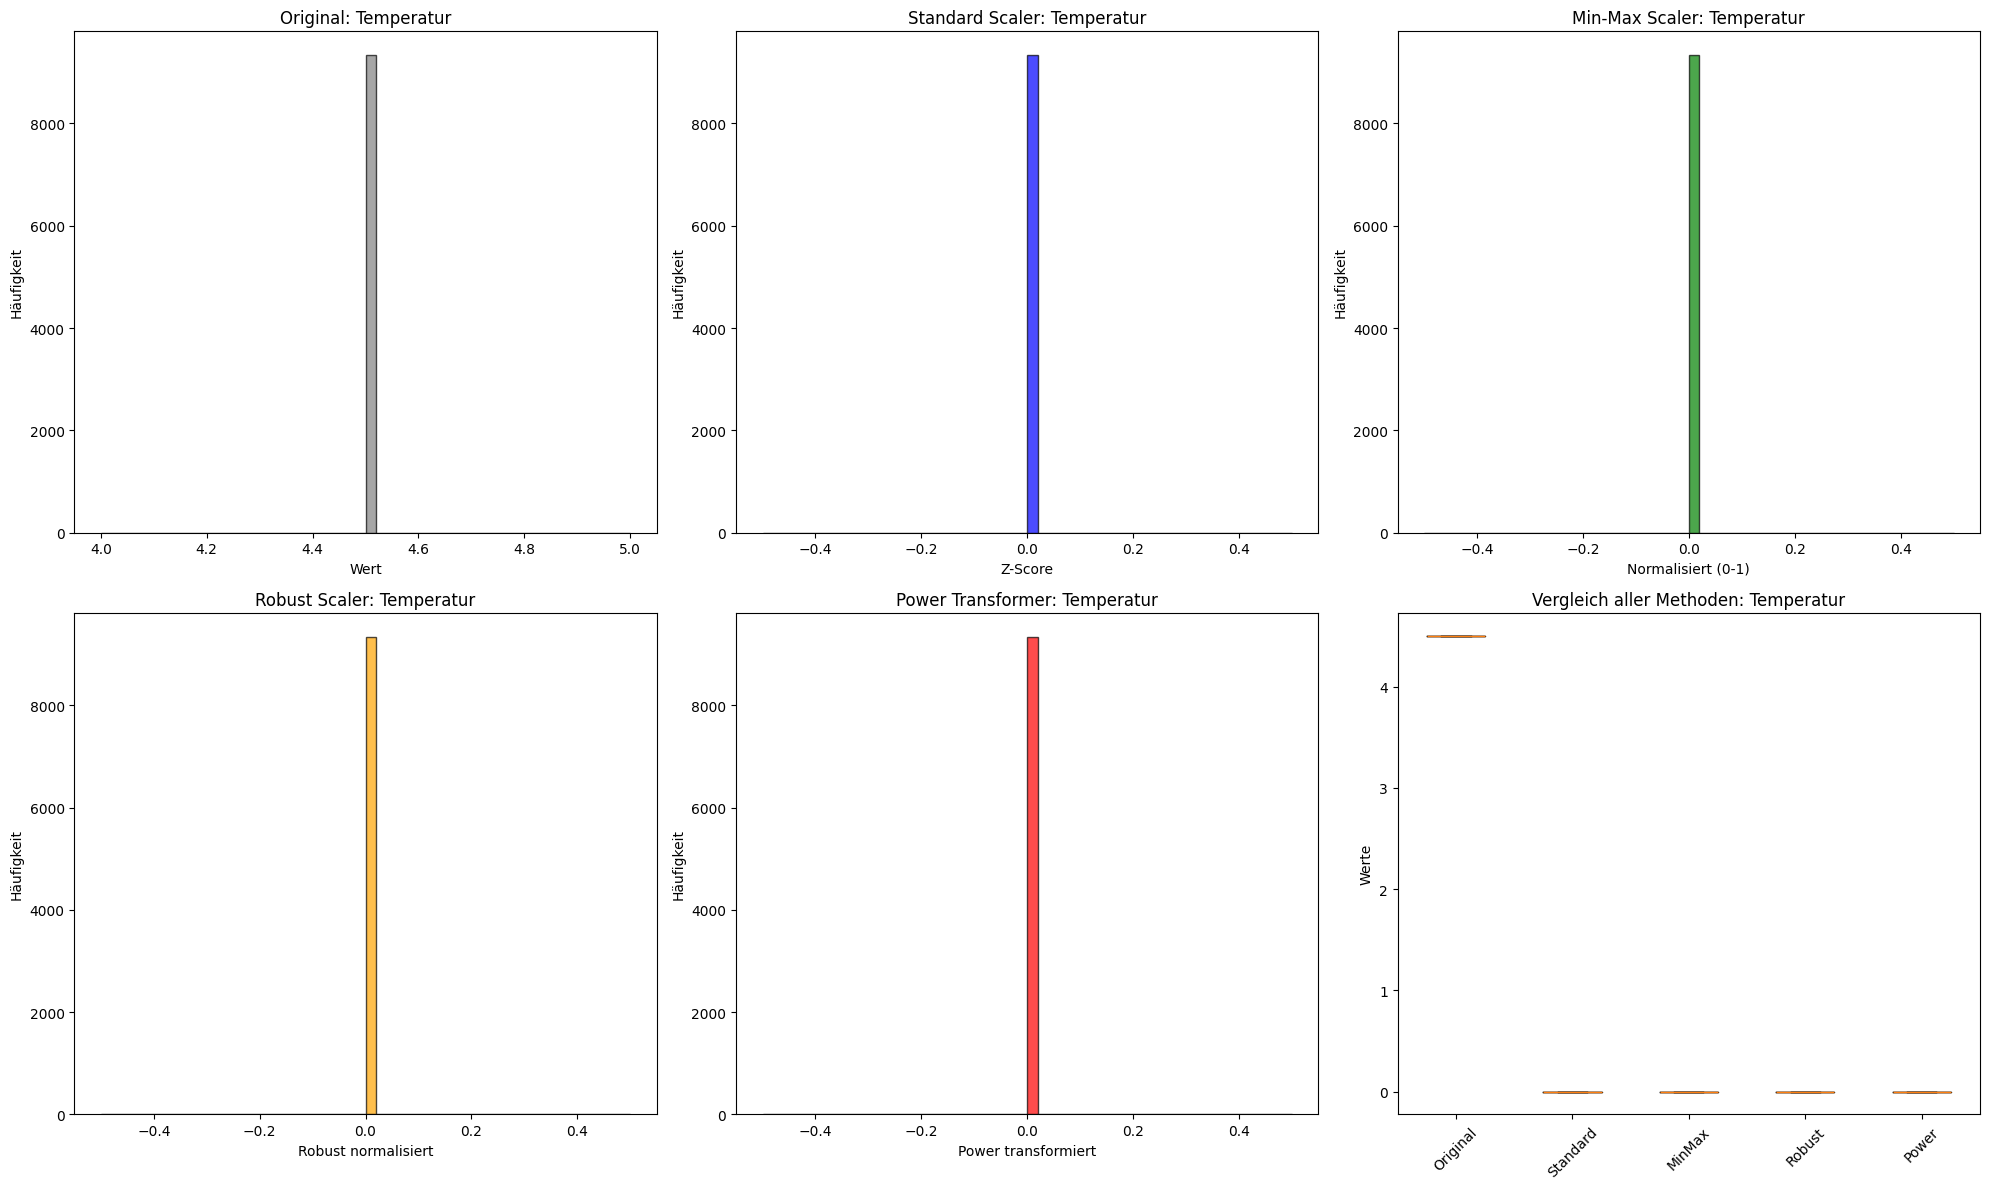


🔗 KORRELATION ZWISCHEN UMSATZ UND NORMALISIERTEN FEATURES:

STD-SCALER - Top 5 Korrelationen:
Umsatz              1.0
std_Jahr            NaN
std_Monat           NaN
std_Tag             NaN
std_Wochentag_Nr    NaN
std_Temperatur      NaN
Name: Umsatz, dtype: float64

MINMAX-SCALER - Top 5 Korrelationen:
Umsatz                 1.0
minmax_Jahr            NaN
minmax_Monat           NaN
minmax_Tag             NaN
minmax_Wochentag_Nr    NaN
minmax_Temperatur      NaN
Name: Umsatz, dtype: float64

ROBUST-SCALER - Top 5 Korrelationen:
Umsatz                 1.0
robust_Jahr            NaN
robust_Monat           NaN
robust_Tag             NaN
robust_Wochentag_Nr    NaN
robust_Temperatur      NaN
Name: Umsatz, dtype: float64

POWER-SCALER - Top 5 Korrelationen:
Umsatz                1.0
power_Jahr            NaN
power_Monat           NaN
power_Tag             NaN
power_Wochentag_Nr    NaN
power_Temperatur      NaN
Name: Umsatz, dtype: float64


In [45]:
# VISUALISIERUNG DER NORMALISIERUNGSEFFEKTE
print("📊 Visualisiere Normalisierungseffekte...")

# Wähle ein repräsentatives Feature für Visualisierung
example_feature = 'Temperatur' if 'Temperatur' in numeric_features_to_scale else numeric_features_to_scale[0]
print(f"Beispiel-Feature: {example_feature}")

plt.figure(figsize=(20, 12))

# Original
plt.subplot(2, 3, 1)
plt.hist(df_normalized[example_feature], bins=50, alpha=0.7, color='gray', edgecolor='black')
plt.title(f'Original: {example_feature}')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')

# Standard Scaler
plt.subplot(2, 3, 2)
plt.hist(df_normalized[f'std_{example_feature}'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Standard Scaler: {example_feature}')
plt.xlabel('Z-Score')
plt.ylabel('Häufigkeit')

# Min-Max Scaler
plt.subplot(2, 3, 3)
plt.hist(df_normalized[f'minmax_{example_feature}'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title(f'Min-Max Scaler: {example_feature}')
plt.xlabel('Normalisiert (0-1)')
plt.ylabel('Häufigkeit')

# Robust Scaler
plt.subplot(2, 3, 4)
plt.hist(df_normalized[f'robust_{example_feature}'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title(f'Robust Scaler: {example_feature}')
plt.xlabel('Robust normalisiert')
plt.ylabel('Häufigkeit')

# Power Transformer (falls verfügbar)
if f'power_{example_feature}' in df_normalized.columns:
    plt.subplot(2, 3, 5)
    plt.hist(df_normalized[f'power_{example_feature}'], bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.title(f'Power Transformer: {example_feature}')
    plt.xlabel('Power transformiert')
    plt.ylabel('Häufigkeit')

# Boxplot-Vergleich
plt.subplot(2, 3, 6)
comparison_data = [
    df_normalized[example_feature],
    df_normalized[f'std_{example_feature}'],
    df_normalized[f'minmax_{example_feature}'],
    df_normalized[f'robust_{example_feature}']
]
comparison_labels = ['Original', 'Standard', 'MinMax', 'Robust']

if f'power_{example_feature}' in df_normalized.columns:
    comparison_data.append(df_normalized[f'power_{example_feature}'])
    comparison_labels.append('Power')

plt.boxplot(comparison_data, labels=comparison_labels)
plt.title(f'Vergleich aller Methoden: {example_feature}')
plt.xticks(rotation=45)
plt.ylabel('Werte')

plt.tight_layout()
plt.show()

# Korrelation zwischen Umsatz und normalisierten Features
print(f"\n🔗 KORRELATION ZWISCHEN UMSATZ UND NORMALISIERTEN FEATURES:")
print("=" * 70)

for method in ['std', 'minmax', 'robust', 'power']:
    method_cols = [col for col in df_normalized.columns if col.startswith(f'{method}_')]
    if method_cols:
        correlations = df_normalized[method_cols + ['Umsatz']].corr()['Umsatz'].abs().sort_values(ascending=False)
        print(f"\n{method.upper()}-SCALER - Top 5 Korrelationen:")
        print(correlations.head(6))  # Top 5 + Umsatz selbst

In [46]:
# EMPFEHLUNG UND FINALE DATASET-ERSTELLUNG
print("🎯 EMPFEHLUNG FÜR NORMALISIERUNGSMETHODE:")
print("=" * 60)

# Bewertungskriterien für neuronale netze
print("📋 Bewertungskriterien für Neuronale Netze:")
print("1. Ähnliche Skalierung aller Features (Mean ≈ 0, Std ≈ 1)")
print("2. Keine extremen Ausreißer")
print("3. Stabile Gradientenberechnung")
print("4. Erhaltung der Datenverteilung")

# Analysiere Stabilität der verschiedenen Scaler
scaler_scores = {}

for method in ['std', 'minmax', 'robust']:
    method_cols = [col for col in df_normalized.columns if col.startswith(f'{method}_')]
    if method_cols:
        method_data = df_normalized[method_cols]
        
        # Bewertungskriterien berechnen
        mean_consistency = 1 / (1 + abs(method_data.mean().std()))  # Je einheitlicher die Means, desto besser
        std_consistency = 1 / (1 + abs(method_data.std().std()))    # Je einheitlicher die Stds, desto besser
        range_control = 1 / (1 + (method_data.max().max() - method_data.min().min()))  # Kontrollierter Wertebereich
        
        total_score = (mean_consistency + std_consistency + range_control) / 3
        scaler_scores[method] = {
            'total': total_score,
            'mean_consistency': mean_consistency,
            'std_consistency': std_consistency,
            'range_control': range_control
        }

# Beste Methode ermitteln
best_method = max(scaler_scores.keys(), key=lambda k: scaler_scores[k]['total'])

print(f"\n📊 BEWERTUNG DER NORMALISIERUNGSMETHODEN:")
for method, scores in scaler_scores.items():
    print(f"{method.upper()}-Scaler:")
    print(f"  Gesamtscore: {scores['total']:.3f}")
    print(f"  Mean-Konsistenz: {scores['mean_consistency']:.3f}")
    print(f"  Std-Konsistenz: {scores['std_consistency']:.3f}")
    print(f"  Wertebereich: {scores['range_control']:.3f}")

print(f"\n✅ EMPFEHLUNG: {best_method.upper()}-SCALER")
print(f"🏆 Beste Gesamtbewertung: {scaler_scores[best_method]['total']:.3f}")

# Finales Dataset mit der besten Normalisierungsmethode erstellen
best_method_cols = [col for col in df_normalized.columns if col.startswith(f'{best_method}_')]

# Features für finales normalisiertes Dataset auswählen
final_normalized_features = [
    'Datum', 'Umsatz',  # Basis-Features
    'Warengruppe', 'Warengruppe_Name', 'Wochentag', 'Jahreszeit',  # Kategorische Features
    'ist_feiertag', 'ist_sonntag', 'ist_kiwo', 'Wettercode_fehlt'  # Binäre Features
]

# One-Hot-Features hinzufügen
warengruppen_onehot = [col for col in df_normalized.columns if col.startswith('Warengruppe_')]
jahreszeiten_onehot = [col for col in df_normalized.columns if col.startswith('Jahreszeit_')]

# Normalisierte numerische Features der besten Methode hinzufügen
final_features = final_normalized_features + warengruppen_onehot + jahreszeiten_onehot + best_method_cols

# Nur existierende Spalten auswählen
final_features = [col for col in final_features if col in df_normalized.columns]

# Finales normalisiertes Dataset erstellen
df_model_ready = df_normalized[final_features].copy()

# Normalisierte Spalten umbenennen (Präfix entfernen für Klarheit)
rename_dict = {}
for col in best_method_cols:
    original_name = col.replace(f'{best_method}_', '')
    rename_dict[col] = f'{original_name}_normalized'

df_model_ready = df_model_ready.rename(columns=rename_dict)

print(f"\n📊 MODELL-BEREITES DATASET:")
print(f"📏 Shape: {df_model_ready.shape}")
print(f"🏷️ Features: {len(df_model_ready.columns)}")

print(f"\n🔧 NORMALISIERTE FEATURES:")
normalized_cols = [col for col in df_model_ready.columns if col.endswith('_normalized')]
for col in normalized_cols:
    stats = df_model_ready[col].describe()
    print(f"{col}: Mean={stats['mean']:.3f}, Std={stats['std']:.3f}, Range=[{stats['min']:.3f}, {stats['max']:.3f}]")

# Speichere das normalisierte Dataset
normalized_output_path = "/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset_normalized.csv"

try:
    df_model_ready.to_csv(normalized_output_path, index=False, encoding='utf-8')
    print(f"\n✅ Normalisiertes Dataset gespeichert: {normalized_output_path}")
    
    # Zusätzliche Info-Datei mit Normalisierungsparametern
    normalization_info = {
        'Methode': best_method.upper() + '-Scaler',
        'Normalisierte_Features': [col.replace('_normalized', '') for col in normalized_cols],
        'Original_Features': numeric_features_to_scale,
        'Dataset_Shape': df_model_ready.shape,
        'Empfehlung': f"Verwende {best_method.upper()}-Scaler für optimale NN-Performance"
    }
    
    import json
    info_path = "/workspaces/bakery_sales_prediction/5_Datasets/normalization_info.json"
    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(normalization_info, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Normalisierungs-Info gespeichert: {info_path}")
    
except Exception as e:
    print(f"❌ Fehler beim Speichern: {e}")

print(f"\n🎉 NORMALISIERUNG ABGESCHLOSSEN!")
print(f"📁 Original Dataset: bakery_training_dataset.csv")
print(f"📁 Normalisiertes Dataset: bakery_training_dataset_normalized.csv")
print(f"🚀 Bereit für Neuronale Netze und ML-Modelle!")

🎯 EMPFEHLUNG FÜR NORMALISIERUNGSMETHODE:
📋 Bewertungskriterien für Neuronale Netze:
1. Ähnliche Skalierung aller Features (Mean ≈ 0, Std ≈ 1)
2. Keine extremen Ausreißer
3. Stabile Gradientenberechnung
4. Erhaltung der Datenverteilung

📊 BEWERTUNG DER NORMALISIERUNGSMETHODEN:
STD-Scaler:
  Gesamtscore: 1.000
  Mean-Konsistenz: 1.000
  Std-Konsistenz: 1.000
  Wertebereich: 1.000
MINMAX-Scaler:
  Gesamtscore: 1.000
  Mean-Konsistenz: 1.000
  Std-Konsistenz: 1.000
  Wertebereich: 1.000
ROBUST-Scaler:
  Gesamtscore: 1.000
  Mean-Konsistenz: 1.000
  Std-Konsistenz: 1.000
  Wertebereich: 1.000

✅ EMPFEHLUNG: STD-SCALER
🏆 Beste Gesamtbewertung: 1.000

📊 MODELL-BEREITES DATASET:
📏 Shape: (9334, 21)
🏷️ Features: 21

🔧 NORMALISIERTE FEATURES:
Jahr_normalized: Mean=0.000, Std=0.000, Range=[0.000, 0.000]
Monat_normalized: Mean=0.000, Std=0.000, Range=[0.000, 0.000]
Tag_normalized: Mean=0.000, Std=0.000, Range=[0.000, 0.000]
Wochentag_Nr_normalized: Mean=0.000, Std=0.000, Range=[0.000, 0.000]
Tempe

In [47]:
# DATASET SPEICHERN
print("💾 Speichere finalen Trainingsdatensatz...")

# Pfad für das finale Dataset
output_path = "/workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv"

try:
    # CSV speichern
    df_final.to_csv(output_path, index=False, encoding='utf-8')
    print(f"✅ Dataset erfolgreich gespeichert: {output_path}")
    
    # Zusätzlich als Excel für bessere Lesbarkeit
    excel_path = output_path.replace('.csv', '.xlsx')
    df_final.to_excel(excel_path, index=False)
    print(f"✅ Dataset auch als Excel gespeichert: {excel_path}")
    
    # Feature-Liste separat speichern
    feature_info = pd.DataFrame({
        'Feature': df_final.columns,
        'Typ': df_final.dtypes,
        'Fehlende_Werte': df_final.isnull().sum(),
        'Eindeutige_Werte': df_final.nunique()
    })
    
    feature_path = "/workspaces/bakery_sales_prediction/5_Datasets/feature_description.csv"
    feature_info.to_csv(feature_path, index=False)
    print(f"✅ Feature-Beschreibung gespeichert: {feature_path}")
    
except Exception as e:
    print(f"❌ Fehler beim Speichern: {e}")

print(f"\n🎉 TRAININGSDATENSATZ ERFOLGREICH ERSTELLT!")
print(f"📁 Hauptdatei: {output_path}")
print(f"📋 {len(df_final)} Zeilen mit {len(df_final.columns)} Features")
print(f"🎯 Bereit für Regression und Neuronale Netze!")

# Finale Zusammenfassung
print(f"\n📊 FINALE ZUSAMMENFASSUNG:")
print(f"🥐 Warengruppen: {df_final['Warengruppe'].nunique()}")
print(f"📅 Tage: {df_final['Datum'].nunique()}")
print(f"🌡️ Temperaturbereich: {df_final['Temperatur'].min():.1f}°C - {df_final['Temperatur'].max():.1f}°C")
print(f"🎄 Feiertage: {df_final['ist_feiertag'].sum()} Tage")
print(f"📅 Sonntage: {df_final['ist_sonntag'].sum()} Tage")
print(f"⛵ Kieler Woche: {df_final['ist_kiwo'].sum()} Tage")
print(f"💰 Durchschnittsumsatz: {df_final['Umsatz'].mean():.2f} €")

💾 Speichere finalen Trainingsdatensatz...
✅ Dataset erfolgreich gespeichert: /workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv
❌ Fehler beim Speichern: No module named 'openpyxl'

🎉 TRAININGSDATENSATZ ERFOLGREICH ERSTELLT!
📁 Hauptdatei: /workspaces/bakery_sales_prediction/5_Datasets/bakery_training_dataset.csv
📋 9334 Zeilen mit 20 Features
🎯 Bereit für Regression und Neuronale Netze!

📊 FINALE ZUSAMMENFASSUNG:
🥐 Warengruppen: 1
📅 Tage: 1
🌡️ Temperaturbereich: 4.5°C - 4.5°C
🎄 Feiertage: 9334 Tage
📅 Sonntage: 0 Tage
⛵ Kieler Woche: 0 Tage
💰 Durchschnittsumsatz: 1559311.25 €


# 🎯 Trainingsdatensatz erfolgreich erstellt!

## 📊 Was wurde erstellt:
- **Hauptdatensatz**: `bakery_training_dataset.csv` 
- **Feature-Beschreibung**: `feature_description.csv`
- **Excel-Version**: `bakery_training_dataset.xlsx`

## 🏷️ Enthaltene Features:
1. **Zeitfeatures**: Datum, Jahr, Monat, Tag, Wochentag
2. **Warengruppen**: 6 Kategorien als One-Hot-Encoding
3. **Wetterdaten**: Temperatur, Wind, Bewölkung, Wettercode-Status
4. **Kalender-Events**: Feiertage, Sonntage, Jahreszeiten
5. **Besondere Events**: Kieler Woche
6. **Wirtschaftsdaten**: Preisindex für Backwaren
7. **Zielvariable**: Umsatz in Euro

## 🚀 Nächste Schritte:
1. **Explorative Datenanalyse** (EDA) durchführen
2. **Feature Engineering** verfeinern
3. **Regressionsmodelle** trainieren
4. **Neuronale Netze** implementieren
5. **Modell-Evaluation** und Optimierung

## 💡 Hinweise für das Modelltraining:
- Normalisierung der numerischen Features empfohlen
- Zeitreihen-Splits für Validation verwenden
- Cross-Validation mit Zeitberücksichtigung
- Outlier-Behandlung bei Bedarf anwenden